<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/main/pso_model_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> 3D Particle Swarm Optimization </h2>

In [ ]:
!pip install --upgrade plotly
!pip install haversine

In [44]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy import interpolate
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

class Obstacle:
  def __init__(self, x, y, z, r):
    self.x = x
    self.y = y
    self.z = z
    self.r = r

class Particle:
  def __init__(self, origin, destination, handles):
    self.origin = origin
    self.destination = destination
    self.handles = handles

    # Define x array
    self.x, self.y, self.z = self.CreatePath(self.origin, self.destination)

    # Define velocity
    self.vx = np.zeros(handles+2)
    self.vy = np.zeros(handles+2)
    self.vz = np.zeros(handles+2)

    # Calculate Cost
    self.Cost()
    
    # Define Best
    self.Best(self.x, self.y, self.z, self.xs, self.ys, self.zs, self.cost)

  def Cost(self):

    # Create spline
    # ts = np.linspace(self.origin[0], self.destination[0], self.handles+2 )

    if self.destination[0] > self.origin[0]:
      ts = np.linspace(self.origin[0], self.destination[0], self.handles+2 )
    else:
      ts = np.linspace(self.destination[0], self.origin[0], self.handles+2 )

    spline_x = interpolate.CubicSpline(ts, self.x)
    spline_y = interpolate.CubicSpline(ts, self.y)
    spline_z = interpolate.CubicSpline(ts, self.z)

    ts2 = np.linspace(self.origin[0], self.destination[0], 100)
    self.xs = spline_x(ts2)
    self.ys = spline_y(ts2)
    self.zs = spline_z(ts2)
    # self.zs = (self.zs/self.zs.max()) * self.zlim

    dsx = spline_x.derivative(nu=1)
    dsy = spline_y.derivative(nu=1)
    dsz = spline_z.derivative(nu=1)

    self.dxs = dsx(ts2)
    self.dys = dsy(ts2)
    self.dzs = dsz(ts2)
    # self.L = np.sum(np.sqrt(self.dxs**2 + self.dys**2 + self.dzs**2))
    self.L = np.sum(np.sqrt(self.dxs**2 + self.dys**2))

    violation = 0
    for i in range(0, len(new_obstacles)):
      # distance_to_obstacle = np.sqrt((self.xs-new_obstacles[i].x)**2+(self.ys-new_obstacles[i].y)**2+(self.zs-new_obstacles[i].z)**2)
      distance_to_obstacle = np.sqrt((self.xs-new_obstacles[i].x)**2+(self.ys-new_obstacles[i].y)**2)
      v = 1-distance_to_obstacle/new_obstacles[i].r
      for j in range(0,len(v)):
        if v[j] < 0:
          v[j] = 0
      violation += np.mean(v)

    # Z out-of-bounds violation
    # if any(i < 0 for i in self.zs):
    #   violation = 1e10

    # Calculate final cost
    beta = 1000
    self.cost = self.L*(1+beta*violation)

  def Best(self, x, y, z, xs, ys, zs, cost):
    self.best_x = x
    self.best_y = y
    self.best_z = z

    self.best_xs = xs
    self.best_ys = ys
    self.best_zs = zs

    self.best_cost = cost

  def CreatePath(self, start, end):
    x = np.random.uniform(start[0], end[0], self.handles+2)
    x[0] = start[0]
    x[-1] = end[0]

    y = np.random.uniform(start[1], end[1], self.handles+2)
    y[0] = start[1]
    y[-1] = end[1]

    # z = np.random.uniform(start[2], end[2], self.handles+2)
    # z[0] = start[2]
    # z[-1] = end[2]
    z = np.linspace(start[2], end[2], self.handles+2)
    
    return x,y,z

class GlobalBest:
  def __init__(self, x, y, z, xs, ys, zs, cost):
    self.x = x
    self.y = y
    self.z = z
    self.xs = xs
    self.ys = ys
    self.zs = zs
    self.cost = cost

# Plotting 3d-Spheres
def ms(x, y, z, radius, resolution=10):
    u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.cos(u)*np.sin(v) + x
    Y = radius * np.sin(u)*np.sin(v) + y
    Z = radius * np.cos(v) + z
    return (X, Y, Z)

# Main
def PSO(origin, destination, geometry, no_particles, handles, iterations, min_limit, max_limit):

  # Create Particle Swarm
  particles = []
  for i in range(no_particles):
    particles.append(Particle(origin, destination, handles))

  # Initialize
  global_best = GlobalBest(0,0,0,0,0,0,1e10)
  for particle in particles:
    if particle.cost < global_best.cost:
      global_best.x = particle.x.copy()
      global_best.y = particle.y.copy()
      global_best.z = particle.z.copy()

      global_best.xs = particle.xs.copy()
      global_best.ys = particle.ys.copy()
      global_best.zs = particle.zs.copy()

      global_best.cost = particle.cost.copy()

  # Particle Swarm Optimization
  canvas_max_x = max_limit[0]
  canvas_min_x = min_limit[0]

  canvas_max_y = max_limit[1]
  canvas_min_y = min_limit[1]

  canvas_max_z = max_limit[2]
  canvas_min_z = min_limit[2]

  iterations = iterations
  w = 1 
  wdamp = .98
  c1 = 1.5
  c2 = 1.5
  alpha = .1
  vel_max_x = alpha*(canvas_max_x - canvas_min_x)
  vel_min_x = -vel_max_x
  vel_max_y = alpha*(canvas_max_y - canvas_min_y)
  vel_min_y = -vel_max_y
  vel_max_z = alpha*(canvas_max_z - canvas_min_z)
  vel_min_z = -vel_max_z

  for i in tqdm(range(0, iterations)):
    
    for particle in particles:

      # X
      particle.vx = w*particle.vx + \
                    c1*np.random.rand(1, handles+2).reshape(handles+2)*(particle.best_x-particle.x) + \
                    c2*np.random.rand(1, handles+2).reshape(handles+2)*(global_best.x-particle.x)
      
      particle.vx = np.maximum(particle.vx.copy(), vel_min_x)
      particle.vx = np.minimum(particle.vx.copy(), vel_max_x)
  
      particle.x = np.add(particle.x, particle.vx, out=particle.x, casting='unsafe')

      # Y
      particle.vy = w*particle.vy + \
                    c1*np.random.rand(1, handles+2).reshape(handles+2)*(particle.best_y-particle.y) + \
                    c2*np.random.rand(1, handles+2).reshape(handles+2)*(global_best.y-particle.y)
      
      particle.vy = np.maximum(particle.vy.copy(), vel_min_y)
      particle.vy = np.minimum(particle.vy.copy(), vel_max_y)

      particle.y = np.add(particle.y, particle.vy, out=particle.y, casting='unsafe')

      # Z
      # particle.vz = w*particle.vz + \
      #               c1*np.random.rand(1, handles+2).reshape(handles+2)*(particle.best_z-particle.z) + \
      #               c2*np.random.rand(1, handles+2).reshape(handles+2)*(global_best.z-particle.z)
      
      # particle.vz = np.maximum(particle.vz.copy(), vel_min_z)
      # particle.vz = np.minimum(particle.vz.copy(), vel_max_z)

      # particle.z = np.add(particle.z, particle.vz, out=particle.z, casting='unsafe')

      # Calculate cost
      particle.Cost()
      if particle.cost < particle.best_cost:
        particle.best_x = particle.x.copy()
        particle.best_y = particle.y.copy()
        particle.best_z = particle.z.copy()

        particle.best_xs = particle.xs.copy()
        particle.best_ys = particle.ys.copy()
        particle.best_zs = particle.zs.copy()

        particle.best_cost = particle.cost.copy()

      if particle.cost < global_best.cost:
        global_best.x = particle.x.copy()
        global_best.y = particle.y.copy()
        global_best.z = particle.z.copy()

        global_best.xs = particle.xs.copy()
        global_best.ys = particle.ys.copy()
        global_best.zs = particle.zs.copy()

        global_best.cost = particle.cost.copy()

    w = w * wdamp

  print(f'\nFinal Global Best Cost: {global_best.cost}')
  return global_best.xs, global_best.ys, global_best.zs, global_best.cost


Define CDR

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

class Drone:
  def __init__(self, speed):
    self.speed = speed
  
  def get_track(self, x, y, z):
    self.x = x
    self.y = y
    self.z = z

    length = 0
    for i in range(0, len(x)):
      try:
        dx = x[i+1]-x[i]
        dy = y[i+1]-y[i]
        dz = z[i+1]-z[i]
        dh = np.sqrt(dx**2+dy**2+dz**2)
        length += dh
      except:
        break
    length = round(length,1)

    time = length/self.speed
    time_vector = np.arange(0, round(time,2)*10 + 1)/10
    xnew = np.linspace(x[0],x[-1],len(time_vector))
    interp = interp1d(x, y)
    yinterp = interp(xnew)
    znew = np.linspace(z[0],z[-1],len(time_vector))
    
    df = pd.DataFrame({'time':time_vector, 'x':xnew, 'y':yinterp, 'z':znew})
    df.x = df.x.round(2)
    df.y = df.y.round(2)
    df.z = df.z.round(2)
    df['pos'] = df[['x','y','z']].apply(tuple, axis=1)

    return df.drop(columns=['x', 'y', 'z'])

  def update_speed(self, speed):
    self.speed = speed
    return self.get_track(self.x, self.y, self.z)

class CDR():
  def __init__(self):
    self.master = []
    self.drones = []
    self.drone_index = 0

  def add_drone(self, drone, track):
    if len(self.master) == 0:
      self.master = drone.get_track(track[0], track[1], track[2])
      self.master.columns = ['time', f'drone_{self.drone_index}']
      self.drones.append(drone)
      self.drone_index += 1
    else:
      self.master = pd.concat([self.master.set_index('time'), drone.get_track(track[0], track[1], track[2]).set_index('time')], axis=1).reset_index()
      self.master.columns = [*self.master.columns[:-1], f'drone_{self.drone_index}']
      self.drones.append(drone)
      self.clean()
      self.drone_index += 1    

  def update_speed(self, drone, to_speed):
    self.master = pd.concat([self.master.set_index('time'), self.drones[drone].update_speed(to_speed).set_index('time')], axis=1).reset_index()
    self.master = self.master.drop(columns=[f'drone_{drone}'])
    self.master.columns = [*self.master.columns[:-1], f'drone_{drone}']
    self.master = self.master.reindex(sorted(self.master.columns), axis=1)
    time_column = self.master.pop('time')
    self.master.insert(0, 'time', time_column)
    self.clean()

  def update_delay(self, drone, units):
    self.master = self.master.reindex(range(len(self.master)+units))
    self.master[f'drone_{drone}'] = self.master[f'drone_{drone}'].shift(units)
    self.clean()
    self.master['time'] = np.arange(0, len(self.master))/10

  def clean(self):
    self.master = self.master.ffill(axis=0)
    self.master = self.master.bfill(axis=0)


Coordinator

In [30]:
# Drones
origins = [(0, 10000, 500), (0, 10000, 500)]
destinations = [(20000, 15000, 500), (20000, 15000, 500)]

max_distance = .5
n = len(origins)

n_origins = []
n_destinations = []
for i in range(0, n):
  for j in range(i+1, n):
    # print(f'{i},{j}')
    dist_origin = np.sqrt((origins[i][0]-origins[j][0])**2+(origins[i][1]-origins[j][1])**2+(origins[i][2]-origins[j][2])**2)
    dist_destination = np.sqrt((destinations[i][0]-destinations[j][0])**2+(destinations[i][1]-destinations[j][1])**2+(destinations[i][2]-destinations[j][2])**2)
    
    if dist_origin <= max_distance and dist_destination <= max_distance:
      n_origins.append(tuple(np.add(origins[i], origins[j])/2))
      n_destinations.append(tuple(np.add(destinations[i], destinations[j])/2))
    else:
      n_origins.append(origins[i])
      n_destinations.append(destinations[i])

    # print(f'Distance Origin: {dist_origin}')
    # print(f'Distance Destination: {dist_destination}')

n_origins = pd.unique(n_origins)
n_destinations = pd.unique(n_destinations)

no_drones = []
for k in range(0, len(n_origins)):
  cumsum = 0
  for m in range(0, len(origins)):
    d = np.sqrt((n_origins[k][0]-origins[m][0])**2+(n_origins[k][1]-origins[m][1])**2+(n_origins[k][2]-origins[m][2])**2)
    if d <= max_distance: cumsum += 1
  no_drones.append(cumsum)

Flights Obstacles

In [ ]:
!pip install pyopensky --upgrade
!mv secret.conf /root/.config/pyopensky/

In [8]:
from pyopensky import OpenskyImpalaWrapper

In [9]:
import pandas as pd
import datetime
from haversine import haversine, inverse_haversine, Unit

# Time of query
def to_epoch(timestamp):
  unix_epoch = datetime.datetime(1970, 1, 1)
  log_dt = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
  seconds_from_epoch = (log_dt - unix_epoch).total_seconds()
  return seconds_from_epoch

from_time_str = '2022-04-22 13:00:00'
to_time_str = '2022-04-22 14:00:00'
from_time = to_epoch(from_time_str)
to_time = to_epoch(to_time_str)

# Area of query
airport = (51.871496514, -0.367665196) # Luton
min_coord = inverse_haversine(airport, 5, np.pi * 1.25)
max_coord = inverse_haversine(airport, 5, np.pi * .25)

# haversine(origin_coord, destination_coord, unit=Unit.METERS)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

# Height of query
min_height, max_height = (0, 2000)

# OpenSky wrapper
opensky = OpenskyImpalaWrapper()
os_query = opensky.rawquery(
    f'SELECT * FROM state_vectors_data4 \
    WHERE lat >= {min_lat} AND lat <= {max_lat} \
    AND lon >= {min_lon} AND lon <= {max_lon} \
    AND hour >= {from_time} AND hour <= {to_time} \
    AND geoaltitude >= {min_height} AND geoaltitude <= {max_height};'
)

try:
  unique_callsigns = pd.unique(os_query['callsign'])
  print(f'Query length: {len(unique_callsigns)}')
except:
  print('No records found')

* Server connection successful!
* Fetching records...
Sending query request: [SELECT * FROM state_vectors_data4     WHERE lat >= 51.839689507099855 AND lat <= 51.903281040706894     AND lon >= -0.41912600917828985 AND lon <= -0.31613156393696185     AND hour >= 1650632400.0 AND hour <= 1650636000.0     AND geoaltitude >= 0 AND geoaltitude <= 2000;]
Processing query result.
* Records downloaded.
Query length: 37


In [31]:
plot_data = []
obstacles = []
obstacles_plot = []
for callsign in unique_callsigns:
  flight = os_query[os_query['callsign'] == callsign].reset_index(drop=True)
  for j in range(0, len(flight)):
    xpos = haversine(min_coord, (min_lat, flight['lon'][j]), unit=Unit.FEET)
    ypos = haversine(min_coord, (flight['lat'][j], min_lon), unit=Unit.FEET)
    obstacles.append(Obstacle(xpos, ypos, flight['geoaltitude'][j], 0))
    obstacles_plot.append([xpos, ypos, flight['geoaltitude'][j]])

print(f'Obstacles: {len(obstacles)}')

Obstacles: 2180


In [32]:
obstacles_plot[0]

[11497.856857201134, 12753.703867497574, 228.6]

In [33]:
new_obstacles = []
xarr = []
yarr = []
for i in range(0, len(obstacles)):
  if obstacles[i].z >= 490 and obstacles[i].z <= 510:
    xarr.append(obstacles[i].x)
    yarr.append(obstacles[i].y)

End
End
End
New obstacles: 53


(4402.367701266436, 19971.896734165675, 5299.080595027347, 19885.935592827136)

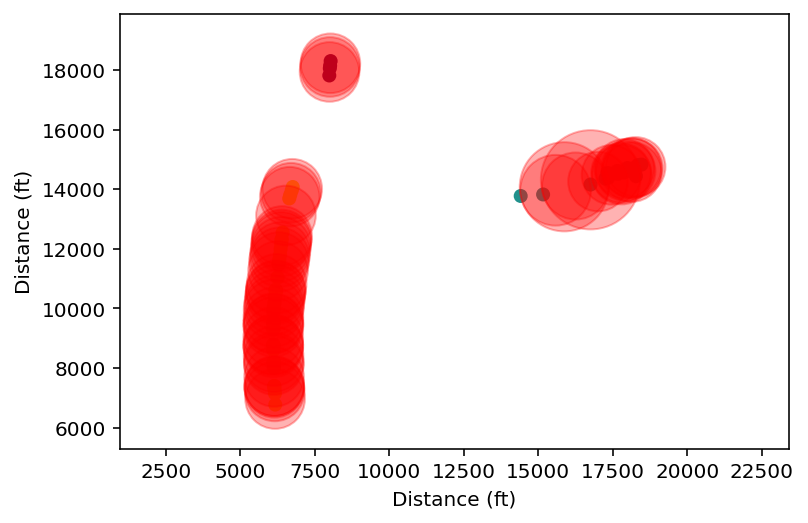

In [35]:
# DBSCAN clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots() 
ax.set_xlabel('Distance (ft)')
ax.set_ylabel('Distance (ft)')

XX = np.array(list(zip(xarr, yarr)))
X = StandardScaler().fit_transform(XX)
clusters = DBSCAN(eps=.5, min_samples=5, algorithm='auto').fit(X)
y_pred = clusters.fit_predict(X)
ax.scatter(XX[:,0], XX[:,1],c=y_pred)
XX = np.array(list(zip(xarr, yarr, y_pred)))

new_obstacles = []
for i in range(0, len(np.unique(y_pred))):
  group = XX[XX[:,2]==np.unique(y_pred)[i]]

  for j in range(0, len(group)):
    try:
      cx = (group[j,0] + group[j+1,0])/2
      cy = (group[j,1] + group[j+1,1])/2
      r = np.sqrt((group[j,0]-group[j+1,0])**2 + (group[j,1]-group[j+1,1])**2)/2
      
      if r < 1000:
        r = 1000

      if len(group) > 2:
        new_obstacles.append(Obstacle(cx, cy, 500, r))
        circle = plt.Circle((cx,cy), r, color='r', alpha=.3)
      else:
        new_obstacles.append(Obstacle(cx, cy, 500, 1000))
        circle = plt.Circle((cx,cy), 1000, color='r',alpha=.3)
      
      ax.add_patch(circle)
    except:
      print('End')
    
print(f'New obstacles: {len(new_obstacles)}')
plt.axis('equal')

PSO

In [47]:
# Create model obstacles
bounds_x = (0, haversine(min_coord, (min_lat, max_lon), unit=Unit.FEET))
bounds_y = (0, haversine(min_coord, (max_lat, min_lon), unit=Unit.FEET))
bounds_z = (min_height, max_height)

# Create CDR
cdr = CDR()

# Run PSO
data = []
colors = ['red', 'blue', 'green']
for i in range(0, len(n_origins)):
  x, y, z, cost = PSO(origin=n_origins[i], destination=n_destinations[i], geometry=obstacles, no_particles=100, \
                    handles=3, iterations=100, min_limit=(bounds_x[0],bounds_y[0],bounds_z[0]), max_limit=(bounds_x[1],bounds_y[1],bounds_z[1]))

  # Append best line
  data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines', name=f'Corridor {i}', line=dict(width=5, color=colors[i])))
  
  for k in range(0, no_drones[i]):
    cdr.add_drone(drone=Drone(speed=1000), track=(x,y,z))

# Append markers
# for j in range(0, len(obstacles)):
    # data.append(go.Scatter3d(x=[obstacles[j].x], y=[obstacles[j].y], z=[obstacles[j].z], mode='markers', marker=dict(color='blue', size=1)))

data.append(go.Scatter3d(
    x=[obstacles_plot[m][0] for m in range(0,len(obstacles_plot))], 
    y=[obstacles_plot[m][1] for m in range(0,len(obstacles_plot))], 
    z=[obstacles_plot[m][2] for m in range(0,len(obstacles_plot))], 
    mode='markers', marker=dict(color='blue', size=1)))

# Append markers
for j in range(0, len(new_obstacles)):
    # data.append(go.Scatter3d(x=[new_obstacles[j].x], y=[new_obstacles[j].y], z=[new_obstacles[j].z], mode='markers', marker=dict(color='red', size=1)))
    
    (x_pns_surface, y_pns_surface, z_pns_surface) = ms(new_obstacles[j].x, new_obstacles[j].y, new_obstacles[j].z, new_obstacles[j].r)
    data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_surface*0.001+500, showscale=False, opacity=1))

# Plot first frame of drones
data.append(go.Scatter3d(
            x=[cdr.master[f'drone_{m}'][0][0] for m in range(0,len(origins))],
            y=[cdr.master[f'drone_{m}'][0][1] for m in range(0,len(origins))],
            z=[cdr.master[f'drone_{m}'][0][2] for m in range(0,len(origins))],
            name='Drone',
            mode="markers",
            marker=dict(color="black", size=5)))

100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Final Global Best Cost: 110.54256174644824


Plot

In [48]:
# layout = go.Layout(scene=dict(
#   aspectmode='manual',
#   aspectratio=dict(x=1, y=(bounds_y[1]-bounds_y[0])/(bounds_x[1]-bounds_x[0]), z=(bounds_z[1]-bounds_z[0])/(bounds_x[1]-bounds_x[0])),
#   bgcolor='rgba(0,0,0,0)',
#   xaxis = dict(range=[bounds_x[0], bounds_x[1]], showgrid=True, gridcolor='rgba(0, 0, 0, .1)', backgroundcolor="rgba(0, 0, 0, 0)", showticklabels=True),
#   yaxis = dict(range=[bounds_y[0], bounds_y[1]], showgrid=True, gridcolor='rgba(0, 0, 0, .1)', backgroundcolor="rgba(0, 0, 0, 0)", showticklabels=True),
#   zaxis = dict(range=[bounds_z[0], bounds_z[1]], showgrid=True, gridcolor='rgba(0, 0, 0, .1)', backgroundcolor="rgba(0, 0, 0, 0)", showticklabels=True)),
#   updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate",args=[None, {'frame':{'duration':1}}])])]
#   )

frames=[go.Frame(
        data=[go.Scatter3d(
            x=[cdr.master[f'drone_{m}'][k][0] for m in range(0,len(origins))],
            y=[cdr.master[f'drone_{m}'][k][1] for m in range(0,len(origins))],
            z=[cdr.master[f'drone_{m}'][k][2] for m in range(0,len(origins))],
            name='Drone',
            mode="markers",
            marker=dict(color="black", size=5))], traces = [len(data)-1])

        for k in range(len(cdr.master.drone_0))]

fig = go.Figure(data=data, frames=frames)

# camera = dict(
#     up=dict(x=0, y=0, z=.1),
#     center=dict(x=0, y=0, z=0),
#     eye=dict(x=0, y=-2, z=3)
# )

# fig.update_layout(scene_camera=camera)

fig.show()

In [ ]:
cdr.update_speed(drone=0, to_speed=5)
cdr.update_speed(drone=1, to_speed=5)

cdr.update_speed(drone=2, to_speed=5)
cdr.update_speed(drone=3, to_speed=5)

cdr.update_delay(drone=1, units=2)

cdr.update_delay(drone=2, units=4)
cdr.update_delay(drone=3, units=6)

In [ ]:
cdr.master

,time,drone_0,drone_1
0,0.0,"(0.0, 0.0, 500.0)","(0.0, 0.0, 500.0)"
1,0.1,"(69.93, 42.69, 500.0)","(69.93, 42.69, 500.0)"
2,0.2,"(139.86, 85.37, 500.0)","(139.86, 85.37, 500.0)"
3,0.3,"(209.79, 128.06, 500.0)","(209.79, 128.06, 500.0)"
4,0.4,"(279.72, 171.94, 500.0)","(279.72, 171.94, 500.0)"
...,...,...,...
282,28.2,"(19720.28, 19819.92, 500.0)","(19720.28, 19819.92, 500.0)"
283,28.3,"(19790.21, 19864.94, 500.0)","(19790.21, 19864.94, 500.0)"
284,28.4,"(19860.14, 19909.96, 500.0)","(19860.14, 19909.96, 500.0)"
285,28.5,"(19930.07, 19954.98, 500.0)","(19930.07, 19954.98, 500.0)"
